# News Classifier

In [2]:
import warnings
warnings.filterwarnings('ignore', module='requests')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## 1. 데이터 다운로드

- [Kaggle AG News Classification Dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset)

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("amananandrai/ag-news-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\amananandrai\ag-news-classification-dataset\versions\2


- 윈도우즈 (로컬 환경)

In [5]:
# !mkdir dataset
!copy "C:\Users\user\.cache\kagglehub\datasets\amananandrai\ag-news-classification-dataset\versions\2\*" dataset

C:\Users\user\.cache\kagglehub\datasets\amananandrai\ag-news-classification-dataset\versions\2\test.csv
C:\Users\user\.cache\kagglehub\datasets\amananandrai\ag-news-classification-dataset\versions\2\train.csv
        2개 파일이 복사되었습니다.


- 리눅스 (colab 환경)

In [6]:
# !cp -r /root/.cache/kagglehub/datasets/amananandrai/ag-news-classification-dataset/versions/2/ ./dataset/

## 2. 데이터 준비

### 데이터 나누기

In [7]:
import pandas as pd
train=pd.read_csv('C:/Users/user/.cache/kagglehub/datasets/amananandrai/ag-news-classification-dataset/versions/2/train.csv')
test=pd.read_csv('C:/Users/user/.cache/kagglehub/datasets/amananandrai/ag-news-classification-dataset/versions/2/test.csv')

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [9]:
train.Description[0]

"Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

In [10]:
import re
re.sub(r"[^a-zA-Z']",' ',train.Description[0])

"Reuters   Short sellers  Wall Street's dwindling band of ultra cynics  are seeing green again "

In [11]:
from sklearn.model_selection import train_test_split
train_df,valid_df=train_test_split(train,stratify=train['Class Index'],test_size=.2)

train_df['Class Index'].value_counts()

4    24000
3    24000
2    24000
1    24000
Name: Class Index, dtype: int64

In [12]:
valid_df['Class Index'].value_counts()

2    6000
4    6000
1    6000
3    6000
Name: Class Index, dtype: int64

**클래스별 분포**

### 텍스트와 레이블 추출

In [25]:
train_texts=train_df['Description'].tolist()
train_texts[0]

'While many high-tech firms scored well in a new study of how they treat customers online, more than a third of the surveyed companies still share personal data without permission.'

In [14]:
import nltk

In [15]:
# 1 빼기
np.array(train_df['Class Index']-1)

array([3, 2, 1, ..., 2, 2, 1], dtype=int64)

In [16]:
# 1 빼기(2)
train_df['Class Index'].values-1

array([3, 2, 1, ..., 2, 2, 1], dtype=int64)

In [17]:
train_texts=train_df['Description'].tolist()
valid_texts=valid_df['Description'].tolist()
test_texts=test['Description'].tolist()

train_labels=train_df['Class Index'].values-1
valid_labels=valid_df['Class Index'].values-1
test_labels=test['Class Index'].values-1


In [37]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train_texts+valid_texts)
sequences = tokenizer.texts_to_sequences(train_texts+valid_texts)

### 데이터 분포 확인

**Vocabulary**

In [19]:
tokenizer.word_counts.items() # 어휘사전, 단어 등장 숫자

odict_items([('while', 1923), ('many', 1380), ('high', 2575), ('tech', 547), ('firms', 330), ('scored', 860), ('well', 928), ('in', 63095), ('a', 86641), ('new', 13841), ('study', 614), ('of', 71508), ('how', 1160), ('they', 4778), ('treat', 98), ('customers', 871), ('online', 1851), ('more', 6169), ('than', 5069), ('third', 3045), ('the', 159156), ('surveyed', 26), ('companies', 1784), ('still', 1357), ('share', 988), ('personal', 570), ('data', 1271), ('without', 812), ('permission', 75), ('prudential', 21), ('equity', 151), ('group', 3210), ('maintained', 57), ('an', 13235), ('quot', 7105), ('overweight', 9), ('rating', 78), ('and', 53375), ('26', 403), ('target', 1810), ('price', 947), ('for', 30635), ('check', 249), ('point', 631), ('software', 3061), ('technologies', 462), ('nasdaq', 449), ('chkp', 2), ('news', 2474), ('people', 3572), ('company', 5457), ('suggested', 150), ('that', 22039), ('although', 377), ('interspect', 1), ('might', 885), ('pakistan', 753), ('captain', 432),

In [31]:
voca=[word for word,cnt in tokenizer.word_counts.items() if cnt>=10]
more_than_10=len(voca)+1 # 10번이상 나온단어
more_than_10

15377

In [30]:
# 사전
tokenizer.word_index

{'<OOV>': 1,
 'the': 2,
 'a': 3,
 'to': 4,
 'of': 5,
 'in': 6,
 'and': 7,
 'on': 8,
 'for': 9,
 '39': 10,
 's': 11,
 'that': 12,
 'with': 13,
 'as': 14,
 'its': 15,
 'at': 16,
 'is': 17,
 'said': 18,
 'by': 19,
 'it': 20,
 'has': 21,
 'new': 22,
 'an': 23,
 'from': 24,
 'reuters': 25,
 'his': 26,
 'was': 27,
 'will': 28,
 'after': 29,
 'have': 30,
 'be': 31,
 'their': 32,
 'two': 33,
 'are': 34,
 'us': 35,
 'over': 36,
 'quot': 37,
 'year': 38,
 'first': 39,
 'ap': 40,
 'he': 41,
 'but': 42,
 'gt': 43,
 'lt': 44,
 'this': 45,
 'more': 46,
 'monday': 47,
 'wednesday': 48,
 'up': 49,
 'tuesday': 50,
 'one': 51,
 'thursday': 52,
 'company': 53,
 'inc': 54,
 'friday': 55,
 'than': 56,
 'world': 57,
 'last': 58,
 'u': 59,
 '1': 60,
 'yesterday': 61,
 'york': 62,
 'they': 63,
 'against': 64,
 'about': 65,
 'who': 66,
 'not': 67,
 'were': 68,
 'into': 69,
 'out': 70,
 'been': 71,
 'three': 72,
 'president': 73,
 '2': 74,
 'had': 75,
 'million': 76,
 'oil': 77,
 'corp': 78,
 'when': 79,
 'week

**Sequence 길이**

In [33]:
len(sequences)
lengths=[len(seq) for seq in sequences]
max_len=int(np.percentile(lengths,95)) # 95% 안에 드는 단어길이
max_len

50

<Axes: >

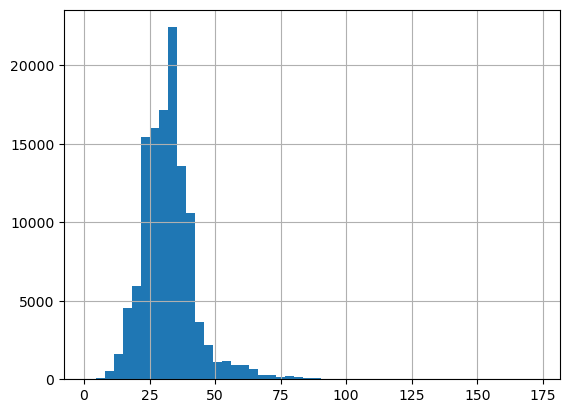

In [34]:
pd.Series(lengths).hist(bins=50)

### 데이터 전처리

In [73]:
# 토큰화
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train_texts+valid_texts)

# 정수화
train_seq = tokenizer.texts_to_sequences(train_texts)
valid_seq = tokenizer.texts_to_sequences(valid_texts)
test_seq = tokenizer.texts_to_sequences(test_texts)

# 패딩
x_train=pad_sequences(train_seq,maxlen=max_len,padding='post', truncating='post')
x_valid=pad_sequences(valid_seq,maxlen=max_len,padding='post', truncating='post')
x_test=pad_sequences(test_seq,maxlen=max_len,padding='post', truncating='post')


In [49]:
x_test

array([[ 183,  280,  126, ...,    0,    0,    0],
       [9578, 2560,   94, ...,    0,    0,    0],
       [ 537,  996, 9997, ...,    0,    0,    0],
       ...,
       [ 854,   20,   91, ...,    0,    0,    0],
       [ 243,    5, 4042, ...,    0,    0,    0],
       [  40,  173, 2044, ...,    0,    0,    0]])

In [52]:
train_labels

array([3, 2, 1, ..., 2, 2, 1], dtype=int64)

In [54]:
# One Hot Encoding
y_train=to_categorical(train_labels)
y_valid=to_categorical(valid_labels)
y_test=to_categorical(test_labels)


## 4. 모델 생성: `NewsClassifier`

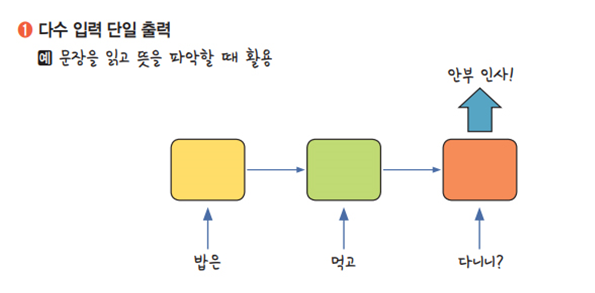

In [89]:
# 모델 하이퍼파라미터
vocab_size=1+len(voca)
VOCAB_SIZE = vocab_size  # 실제 어휘 사전 크기
EMBEDDING_SIZE = 100
LSTM_HIDDEN_DIM = 100
HIDDEN_DIM = 50
NUM_LAYERS = 2
DROPOUT_RATE = 0.2
MAX_LEN = max_len  # 실제 최대 시퀀스 길이
NUM_CLASSES = len(set(train_labels)) # output 수
BATCH_SIZE=32 # 클수록 속도 좀 빠름

In [74]:
x_train.shape,y_train.shape,x_valid.shape,y_valid.shape

((96000, 50), (96000, 4), (24000, 50), (24000, 4))

## 모델 훈련

In [75]:
import tensorflow as tf
from tensorflow.keras import layers
model1 = tf.keras.Sequential([
    # todo
    layers.Embedding(input_dim=VOCAB_SIZE,output_dim=EMBEDDING_SIZE,input_length=MAX_LEN),
    layers.SimpleRNN(units=HIDDEN_DIM,return_sequences=False),
    layers.Dense(units=NUM_CLASSES,activation='softmax')
])
model1.summary()
model1.compile(optimizer=tf.keras.optimizers.Adam(0.001),
               loss='categorical_crossentropy',
               metrics=["accuracy"])
history1 = model1.fit(x_train, y_train, epochs=1,batch_size=BATCH_SIZE,validation_data=(x_valid,y_valid))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 100)           1537700   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                7550      
                                                                 
 dense_6 (Dense)             (None, 4)                 204       
                                                                 
Total params: 1,545,454
Trainable params: 1,545,454
Non-trainable params: 0
_________________________________________________________________
6000/6000 [==============================] - 239s 40ms/step - loss: 1.0102 - accuracy: 0.5644 - val_loss: 0.8032 - val_accuracy: 0.6959


In [81]:
inputs=layers.Input(shape=(MAX_LEN,))
embeddings=layers.Embedding(input_dim=VOCAB_SIZE,output_dim=EMBEDDING_SIZE)(inputs)
hidden=layers.SimpleRNN(units=HIDDEN_DIM,return_sequences=False)(embeddings)
outputs=layers.Dense(units=NUM_CLASSES,activation='softmax')(hidden)
#------------------------------------------------------------------------------------------------#

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)
model2.summary()

model2.compile(optimizer=tf.keras.optimizers.Adam(0.001),
               loss='categorical_crossentropy',
               metrics=["accuracy"])
history2 = model2.fit(x_train, y_train, epochs=1,batch_size=BATCH_SIZE,validation_data=(x_valid,y_valid))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_13 (Embedding)    (None, 50, 100)           1537700   
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 50)                7550      
                                                                 
 dense_12 (Dense)            (None, 4)                 204       
                                                                 
Total params: 1,545,454
Trainable params: 1,545,454
Non-trainable params: 0
_________________________________________________________________
6000/6000 [==============================] - 236s 39ms/step - loss: 0.9921 - accuracy: 0.5526 - val_loss: 1.2785 - val_accuracy: 0.4211


In [83]:
# LSTM
import tensorflow as tf
from tensorflow.keras import layers
model_LSTM = tf.keras.Sequential([
    # todo
    layers.Embedding(input_dim=VOCAB_SIZE,output_dim=EMBEDDING_SIZE,input_length=MAX_LEN),
    layers.LSTM(units=HIDDEN_DIM,return_sequences=False),
    layers.Dense(units=NUM_CLASSES,activation='softmax')
])
model_LSTM.summary()
model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(0.001),
               loss='categorical_crossentropy',
               metrics=["accuracy"])
history3 = model_LSTM.fit(x_train, y_train, epochs=1,batch_size=BATCH_SIZE,validation_data=(x_valid,y_valid))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 50, 100)           1537700   
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense_14 (Dense)            (None, 4)                 204       
                                                                 
Total params: 1,568,104
Trainable params: 1,568,104
Non-trainable params: 0
_________________________________________________________________
6000/6000 [==============================] - 59s 8ms/step - loss: 0.4799 - accuracy: 0.8098 - val_loss: 0.3158 - val_accuracy: 0.8909


## 모델 예측

In [86]:
def predict_category(text, model, tokenizer, max_len=100):
    # 1. 텍스트를 시퀀스로 변환 및 패딩
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_len)

    # 2. 모델 예측
    proba = model.predict(padded, verbose=False)[0]
    predict = np.argmax(proba) + 1  # 0번 클래스를 1번으로 매핑
    probability = np.max(proba)
    return predict, probability

# 테스트 샘플 준비
test_samples = {}
for category in test['Class Index'].unique():
    test_samples[category] = test[test['Class Index'] == category]['Description'].tolist()[-5:]

category_map = {1:"World", 2:"Sports", 3:"Business", 4:"Sci/Tech"}

# 예측 실행
for truth, samples in test_samples.items():
    print(f"True Category: {category_map[truth]}")
    print('='*50)
    for sample in samples:
        predict, probability = predict_category(sample, model_LSTM, tokenizer, max_len)
        print(f"예측: {category_map[predict]} (p={probability:.2f})")
        print(f"샘플: {sample}")
        print('-'*30)
    print()


True Category: Business
예측: Business (p=0.52)
샘플: MOSCOW (AFP) - Russia forged ahead with the weekend auction of the core asset of crippled oil giant Yukos despite a disputed US court order barring the sale, with state-controlled gas giant Gazprom entering the bidding.
------------------------------
예측: Business (p=0.84)
샘플: The head of plane maker Airbus yesterday won a bitter battle to oust his boss from the helm of parent aerospace group Eads after winning the support of a key shareholder.
------------------------------
예측: Business (p=0.67)
샘플: Standard  amp; Poor #39;s Equity Research said the purchase of Rent.com by eBay (nasdaq: EBAY - news - people ) could be a bit of a miscalculation.
------------------------------
예측: Business (p=0.54)
샘플: SINGAPORE : Doctors in the United States have warned that painkillers Bextra and Celebrex may be linked to major cardiovascular problems and should not be prescribed.
------------------------------
예측: Business (p=0.57)
샘플: EBay plans to bu

## 모델 평가

In [91]:
loss, accuracy = model_LSTM.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

238/238 [==============================] - 1s 4ms/step - loss: 0.3259 - accuracy: 0.8909
Test Accuracy: 0.8909
